# Fundamentos de analítica 2 (clase 1)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (TD_13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(220, 4)


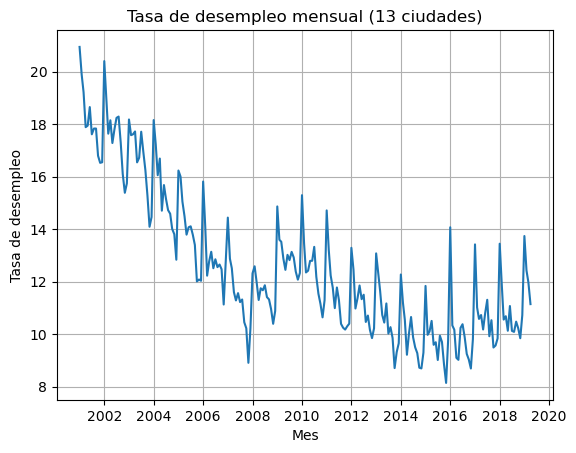

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["TD_13ciudades"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose. 

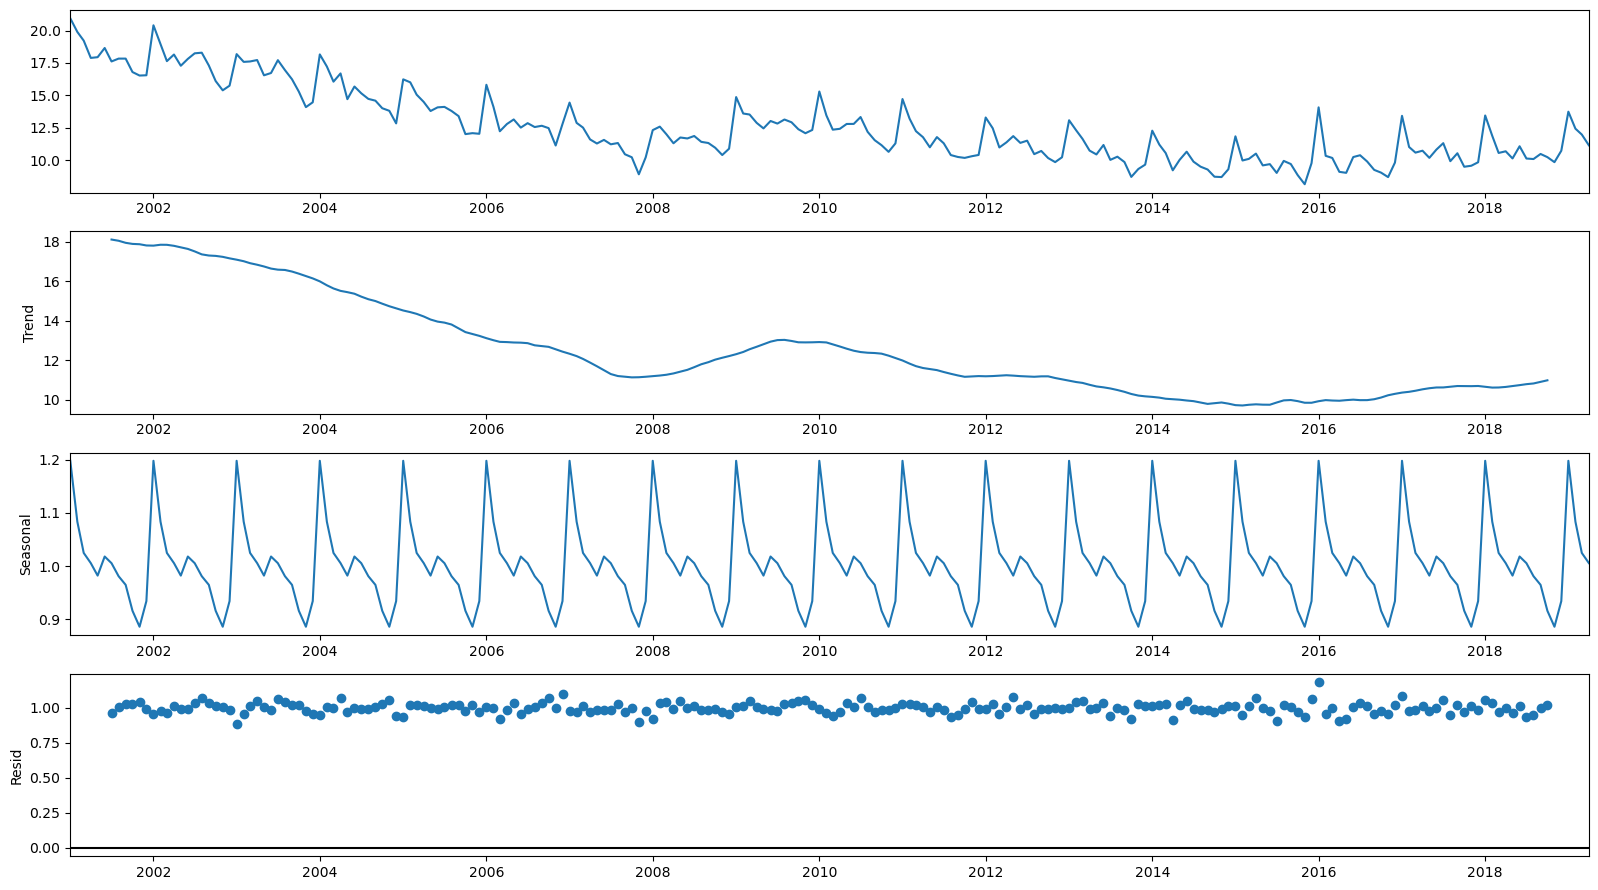

In [5]:
td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="multiplicative")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

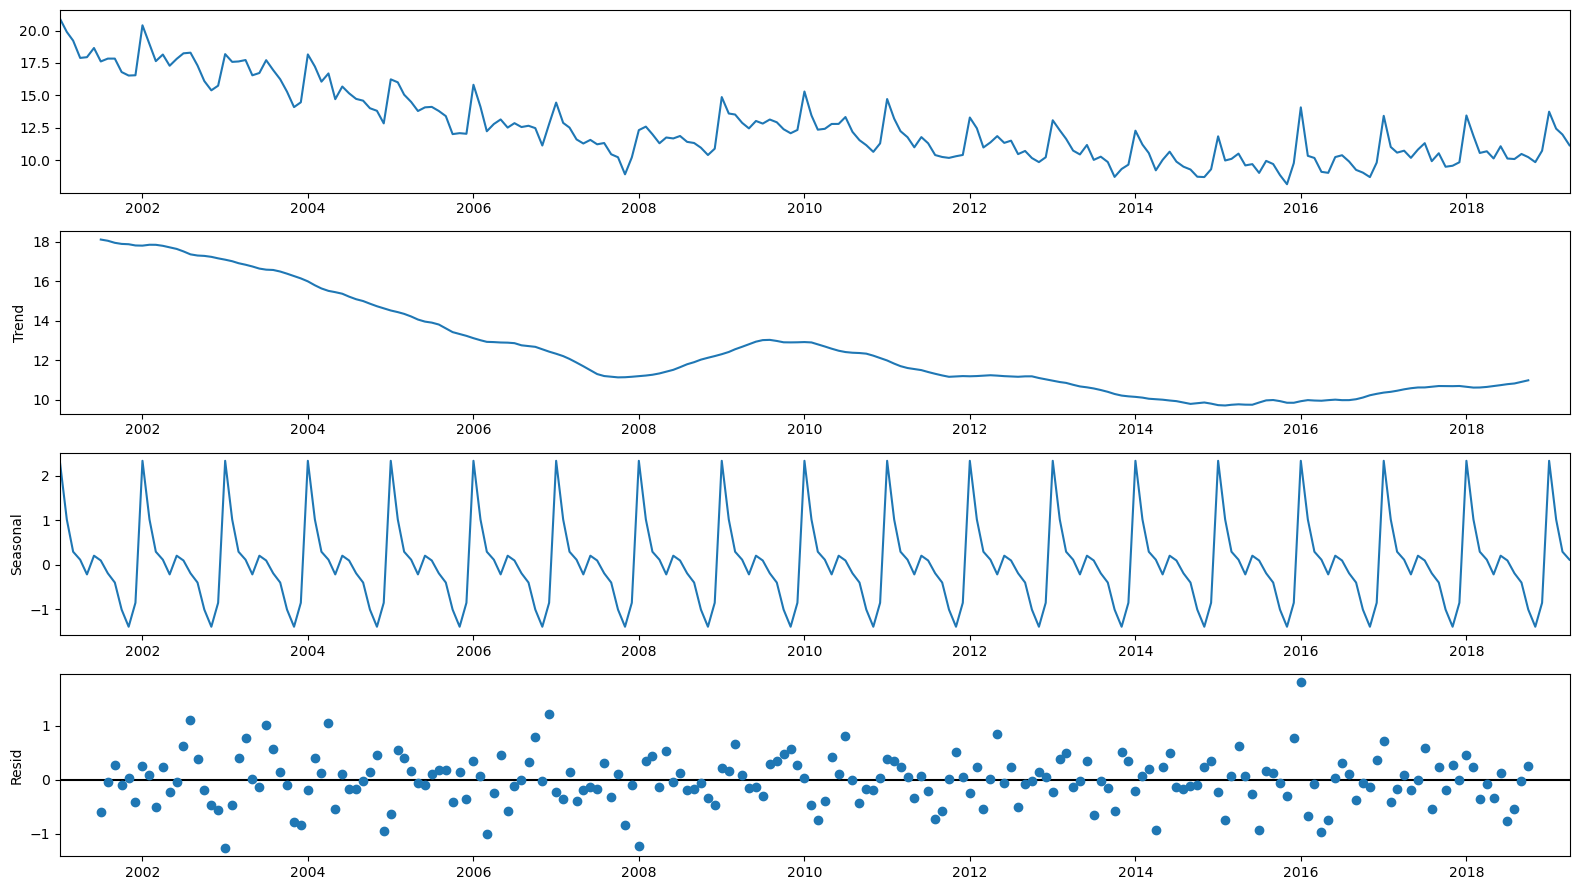

In [4]:
td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01    2.341068
2001-02-01    1.020286
2001-03-01    0.293373
2001-04-01    0.113895
2001-05-01   -0.217028
                ...   
2018-12-01   -0.856036
2019-01-01    2.341068
2019-02-01    1.020286
2019-03-01    0.293373
2019-04-01    0.113895
Name: seasonal, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

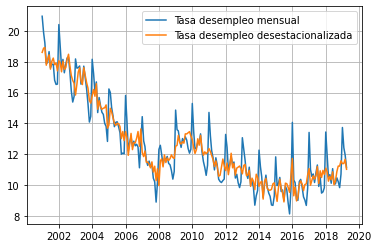

In [6]:
td_desestacionalizada = data["TD_13ciudades"]-td_componentes.seasonal

plt.plot(data[["TD_13ciudades"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos. 

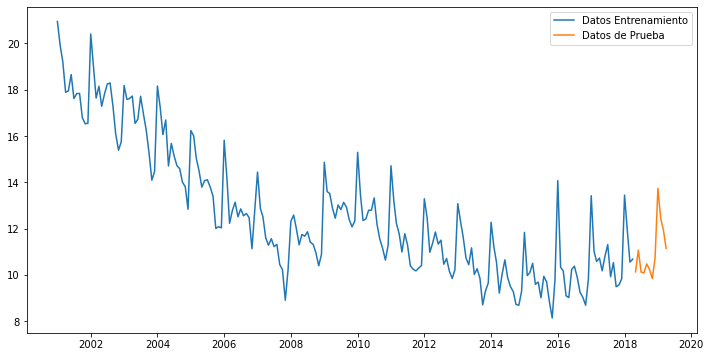

In [7]:
train_len = 208
train_td = data[["TD_13ciudades"]][:train_len]
test_td = data[["TD_13ciudades"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [ ]:
train_td

,TD_13ciudades
mes,
2001-01-01,20.946380
2001-02-01,19.894213
2001-03-01,19.221565
2001-04-01,17.888575
2001-05-01,17.945654
...,...
2017-12-01,9.837395
2018-01-01,13.446245
2018-02-01,11.874973


In [ ]:
test_td

,TD_13ciudades
mes,
2018-05-01,10.129211
2018-06-01,11.071347
2018-07-01,10.125100
2018-08-01,10.085244
2018-09-01,10.476567
2018-10-01,10.230811
2018-11-01,9.844539
2018-12-01,10.725865
2019-01-01,13.739328


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [8]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [9]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [10]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [11]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [12]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [13]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

1.1781369446057537 1.149344676431958 1.167290983502916 1.1536277219669278


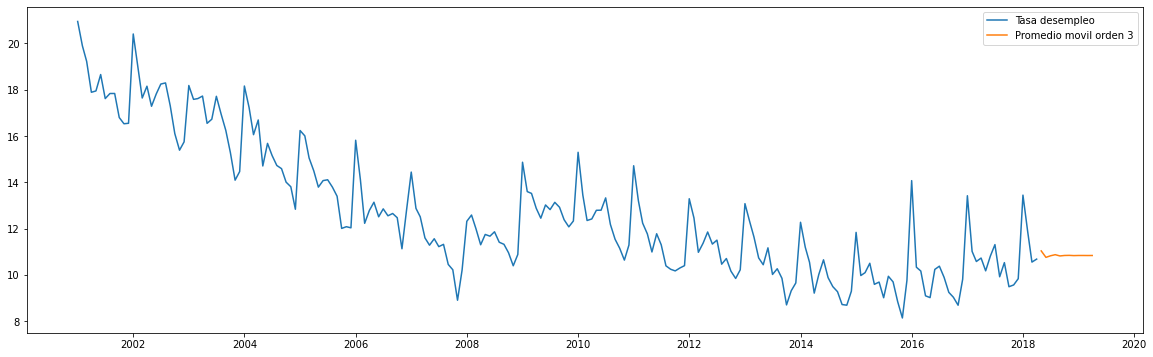

In [14]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [15]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast  lower_95   upper_95
2018-05-01       10.959788  8.650409  13.269166
2018-06-01       10.959788  8.505554  13.414021
2018-07-01       10.959788  8.368785  13.550791
2018-08-01       10.959788  8.238882  13.680694
2018-09-01       10.959788  8.114905  13.804671
2018-10-01       10.959788  7.996109  13.923467
2018-11-01       10.959788  7.881895  14.037681
2018-12-01       10.959788  7.771770  14.147806
2019-01-01       10.959788  7.665324  14.254252
2019-02-01       10.959788  7.562211  14.357365
2019-03-01       10.959788  7.462137  14.457439
2019-04-01       10.959788  7.364848  14.554728


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


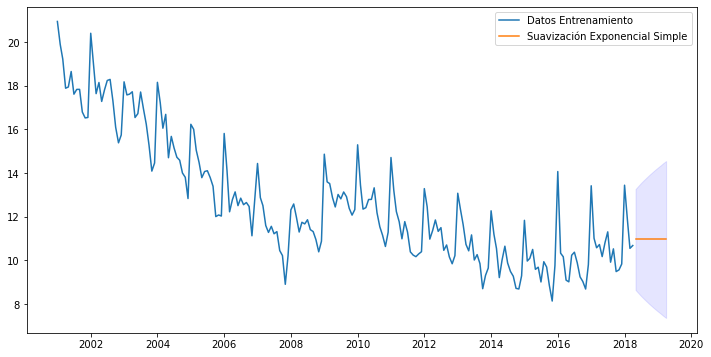

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.3596639.Y el RMSE en la muestra de evaluación es 1.12

In [ ]:
ets_result.alpha

0.359699529804786

In [ ]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

1.1244217727305756


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [ ]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast  lower_95   upper_95
2018-05-01       10.660589  8.687748  12.708082
2018-06-01       10.632892  8.705061  12.861902
2018-07-01       10.605267  8.433946  12.717684
2018-08-01       10.577713  8.462494  12.714967
2018-09-01       10.550231  8.421015  12.963952
2018-10-01       10.522821  8.356943  12.822985
2018-11-01       10.495482  8.350445  12.710885
2018-12-01       10.468214  8.106170  12.635024
2019-01-01       10.441016  8.247874  12.800458
2019-02-01       10.413890  8.202142  12.730885
2019-03-01       10.386833  8.239276  12.819718
2019-04-01       10.359848  8.006249  12.903123


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


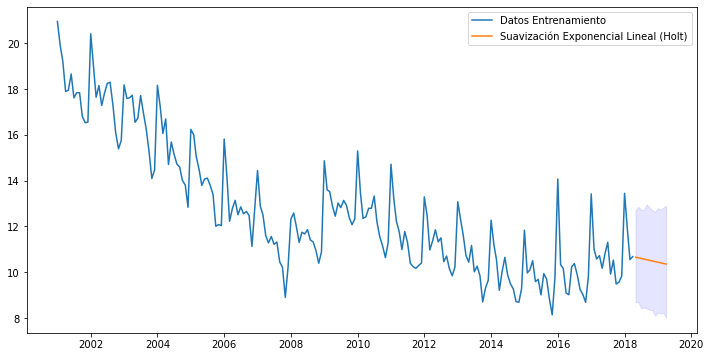

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.17153975893378887 y el β estimado es 1.7153975893378887$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [ ]:
print(ets_result.alpha,ets_result.beta)

0.17153975893378887 1.7153975893378887e-05


In [ ]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

1.2780044501304348


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [ ]:
# Build model
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


            Point_forecast   lower_95   upper_95
2018-05-01       10.297313   9.251501  11.343125
2018-06-01       10.674302   9.532332  11.816272
2018-07-01       10.565091   9.334437  11.795746
2018-08-01       10.226572   8.913191  11.539952
2018-09-01        9.946371   8.555160  11.337582
2018-10-01        9.282589   7.817663  10.747516
2018-11-01        8.875116   7.339996  10.410236
2018-12-01        9.376542   7.774288  10.978797
2019-01-01       12.534280  10.867581  14.200980
2019-02-01       11.193038   9.464281  12.921794
2019-03-01       10.434224   8.645551  12.222896
2019-04-01       10.158488   8.311830  12.005145


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


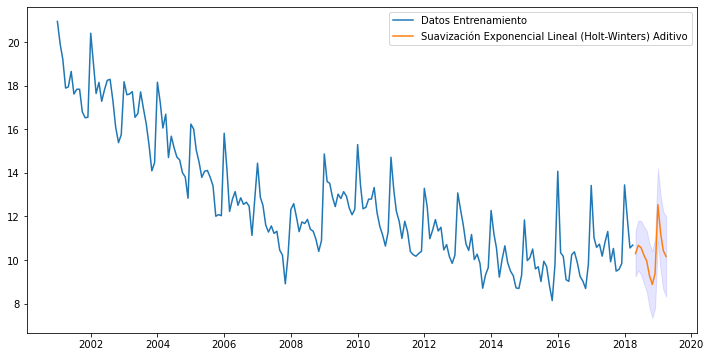

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.4385291272708879 4.3852912727088794e-05 5.614708727291121e-05


In [ ]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

0.9426052953727854


In [ ]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


            Point_forecast   lower_95   upper_95
2018-05-01       10.433036   9.383293  11.605989
2018-06-01       10.981856   9.772505  12.192912
2018-07-01       10.779516   9.479282  12.090921
2018-08-01       10.380957   9.081244  11.755214
2018-09-01       10.300534   8.859445  11.764439
2018-10-01        9.708898   8.184470  11.143706
2018-11-01        9.565507   8.041310  11.197594
2018-12-01       10.265134   8.555668  12.202937
2019-01-01       13.399530  11.337972  15.602496
2019-02-01       11.447407   9.623302  13.514263
2019-03-01       10.843306   9.031314  12.835818
2019-04-01       10.618172   8.822003  12.583608


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


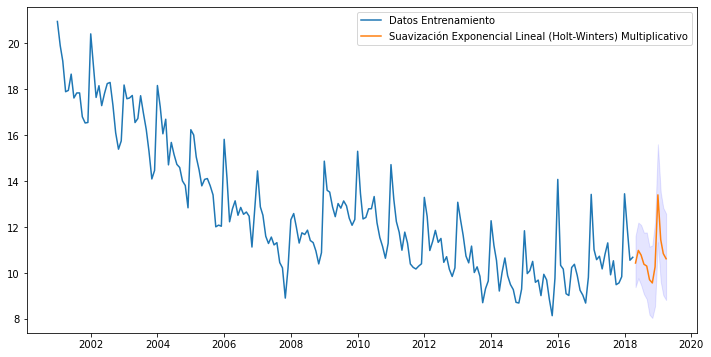

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.gamma)

0.43149821545372236 0.16097082469992063


In [ ]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

0.5659175692143992


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.